<a href="https://colab.research.google.com/github/himanshu911/diffusion-model-for-landscapes/blob/main/genLandscapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install accelerate
!pip install -q kaggle

## Import Libraries

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

from miniai.imports import *
from miniai.diffusion import *

from fastprogress import progress_bar
from diffusers import AutoencoderKL, UNet2DConditionModel
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import timm
import shutil
import os
import json
from glob import glob
import warnings

In [ ]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

# kaggle api token
os.environ['KAGGLE_USERNAME'] = 'your_username'
os.environ['KAGGLE_KEY'] = 'your_kaggle_api_key'

### Load Data

In [ ]:
path = Path('data')
path.mkdir(exist_ok=True)

In [ ]:
%%time
!kaggle datasets download -p {path} --unzip hshukla/landscapes

100% 12.0G/12.0G [02:37<00:00, 80.8MB/s]
100% 12.0G/12.0G [02:37<00:00, 81.5MB/s]
CPU times: user 3.29 s, sys: 512 ms, total: 3.81 s
Wall time: 5min 8s


### Data Processing

In [ ]:
bs = 32

In [ ]:
tfms = nn.Sequential(T.Resize(256))

def to_img(f): return read_image(f, mode=ImageReadMode.RGB)/255

class ImagesDS:
    def __init__(self, spec):
        self.path = Path(path)
        self.files = glob(str(spec), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
      return tfms(to_img(self.files[i]))

In [ ]:
ds = ImagesDS(path/f'**/*.jpg')
dl = DataLoader(ds, batch_size=bs, num_workers=fc.defaults.cpus)

torch.Size([32, 3, 256, 256])


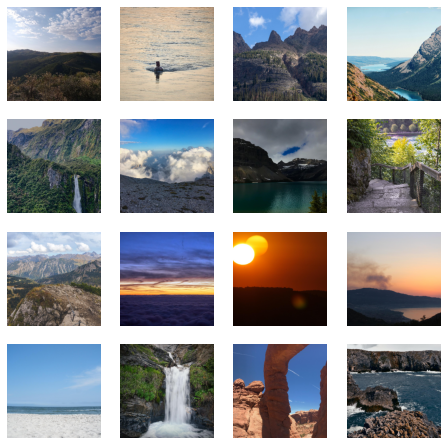

In [ ]:
xb = next(iter(dl))
print(xb.shape)

show_images(xb[:16], imsize=2)

### VAE

In [ ]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").to(def_device).requires_grad_(False)

torch.Size([16, 4, 32, 32])


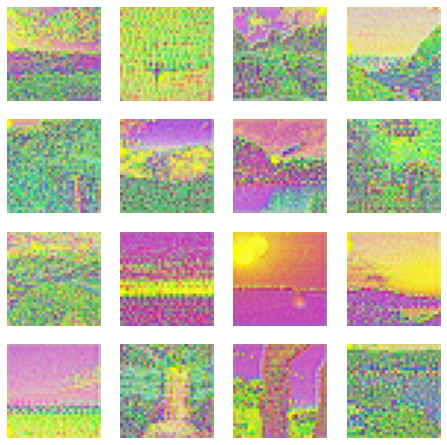

In [ ]:
xe = vae.encode(xb.to(def_device))

xs = xe.latent_dist.mean[:16]
print(xs.shape)

show_images(((xs[:16,:3])/4).sigmoid(), imsize=2)

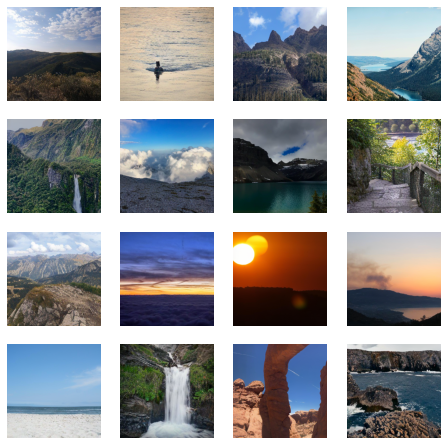

In [ ]:
xd = to_cpu(vae.decode(xs))
show_images(xd['sample'].clamp(0,1), imsize=2)

In [ ]:
len(ds)

90000

In [ ]:
mmpath = path/'lhq.npmm'
mmshape = (90000,4,32,32)

In [ ]:
if not mmpath.exists():
    a = np.memmap(mmpath, np.float32, mode='w+', shape=mmshape)
    i = 0
    for b in progress_bar(dl):
        n = len(b)
        a[i:i+n] = to_cpu(vae.encode(b.to(def_device)).latent_dist.mean).numpy()
        i += n
    a.flush()
    del(a)

In [ ]:
lats = np.memmap(mmpath, dtype=np.float32, mode='r', shape=mmshape)
len(lats)

90000

In [ ]:
torch.tensor(lats).mean(), torch.tensor(lats).std(), (torch.tensor(lats)*0.2).std()

(tensor(1.1655), tensor(4.6209), tensor(0.9242))

torch.Size([16, 4, 32, 32])


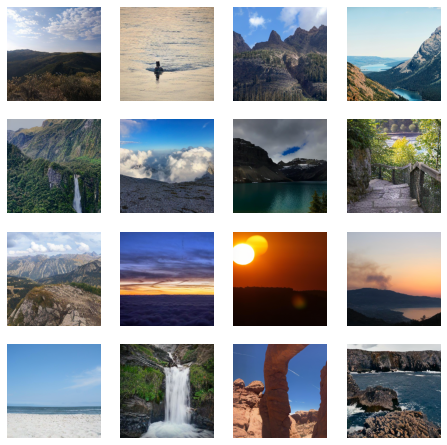

In [ ]:
b = torch.tensor(lats[:16])
print(b.shape)

xd = to_cpu(vae.decode(b.to(def_device)))
show_images(xd['sample'].clamp(0,1), imsize=2)

### Noisify

In [ ]:
bs = 128

In [ ]:
n = len(lats)

tds = lats[:n//10*9 ]
vds = lats[ n//10*9:]

len(tds), len(vds)

(81000, 9000)

In [ ]:
def collate_ddpm(b): return noisify(default_collate(b)*0.2) # adjusted for unit std deviation
dls = DataLoaders(*get_dls(tds, vds, bs=bs, num_workers=fc.defaults.cpus, collate_fn=collate_ddpm))

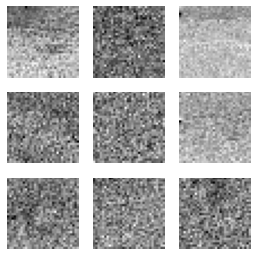

In [ ]:
(xt,t),eps = b = next(iter(dls.train))
show_images(xt[:9,0], imsize=1.5)

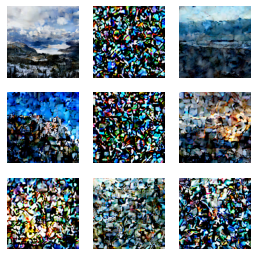

In [ ]:
xte = vae.decode(xt[:9].cuda()*5)['sample']
show_images(xte.clamp(0,1), imsize=1.5)

### Training

In [ ]:
model_path = path/'lhq_diffusion-latents.pkl'

In [ ]:
def init_ddpm(model):
    for o in model.downs:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

    for o in model.ups:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

In [ ]:
lr = 3e-3
epochs = 8
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=4, out_channels=4, nfs=(128, 256, 512, 768), num_layers=2,
                     attn_start=1, attn_chans=16)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

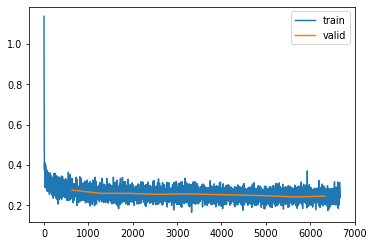

In [ ]:
if not model_path.exists():
    learn.fit(epochs)
    torch.save(learn.model.state_dict(), model_path)

In [ ]:
if model_path.exists():
    state = torch.load(model_path, map_location='cpu') if def_device == 'cpu' else torch.load(model_path)
    model.load_state_dict(state)
    model = model.to(def_device)

### Sampling

In [ ]:
sz = (16,4,32,32)

In [ ]:
# set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=False)

In [ ]:
s = preds[-1]*5   #reversing the adjustment for unit std deviation

In [ ]:
with torch.no_grad(): pd = to_cpu(vae.decode(s.to(def_device)))

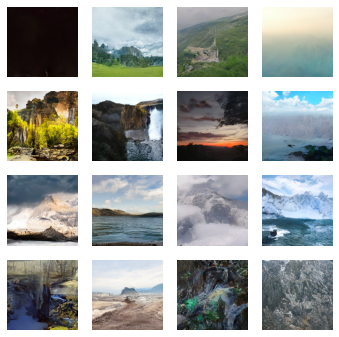

In [ ]:
show_images(pd['sample'].clamp(0,1), imsize=1.5)

### Generate New Landscapes

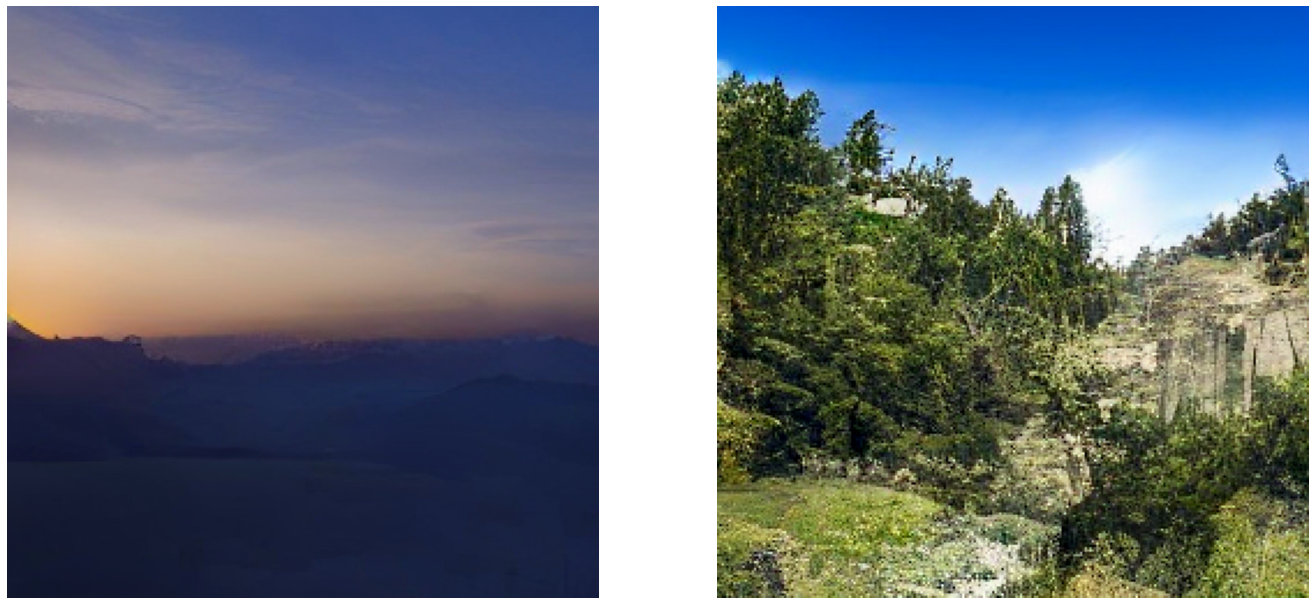

In [ ]:
with torch.no_grad(): pd = to_cpu(vae.decode(s.to(def_device)))

preds = sample(ddim_step, model, (2,4,32,32), steps=100, eta=1., clamp=False)
s = preds[-1]*5

with torch.no_grad(): pd = to_cpu(vae.decode(s.to(def_device)))

show_images(pd['sample'].clamp(0,1), imsize=12)

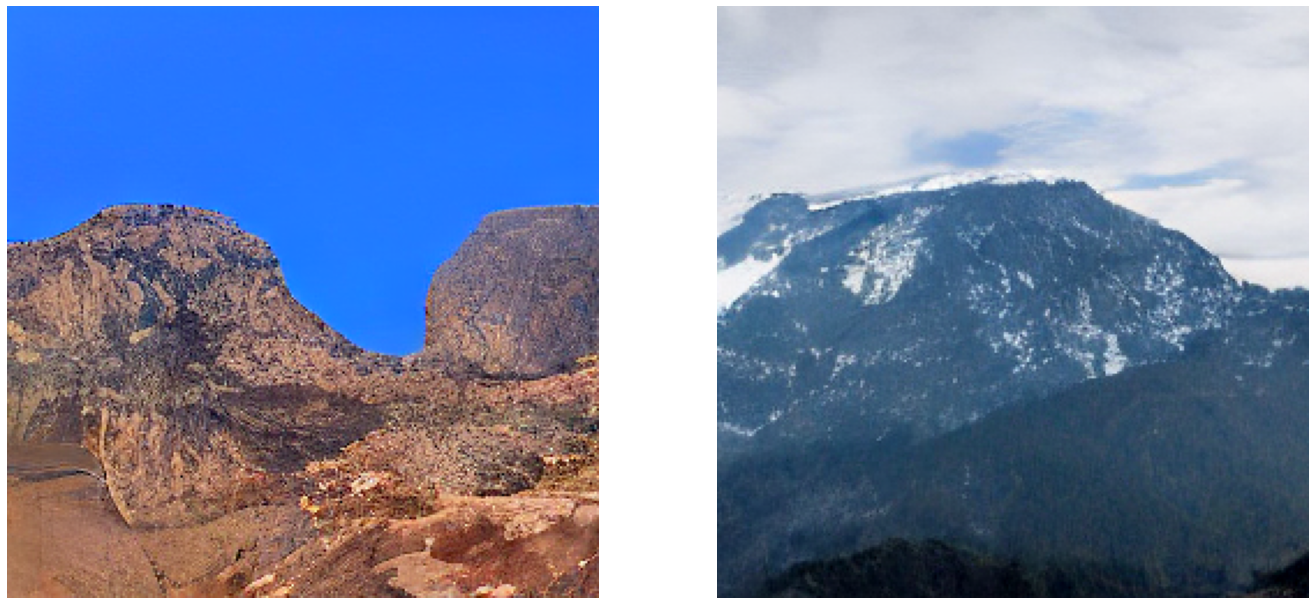

In [ ]:
with torch.no_grad(): pd = to_cpu(vae.decode(s.to(def_device)))

preds = sample(ddim_step, model, (2,4,32,32), steps=100, eta=1., clamp=False)
s = preds[-1]*5

with torch.no_grad(): pd = to_cpu(vae.decode(s.to(def_device)))

show_images(pd['sample'].clamp(0,1), imsize=12)

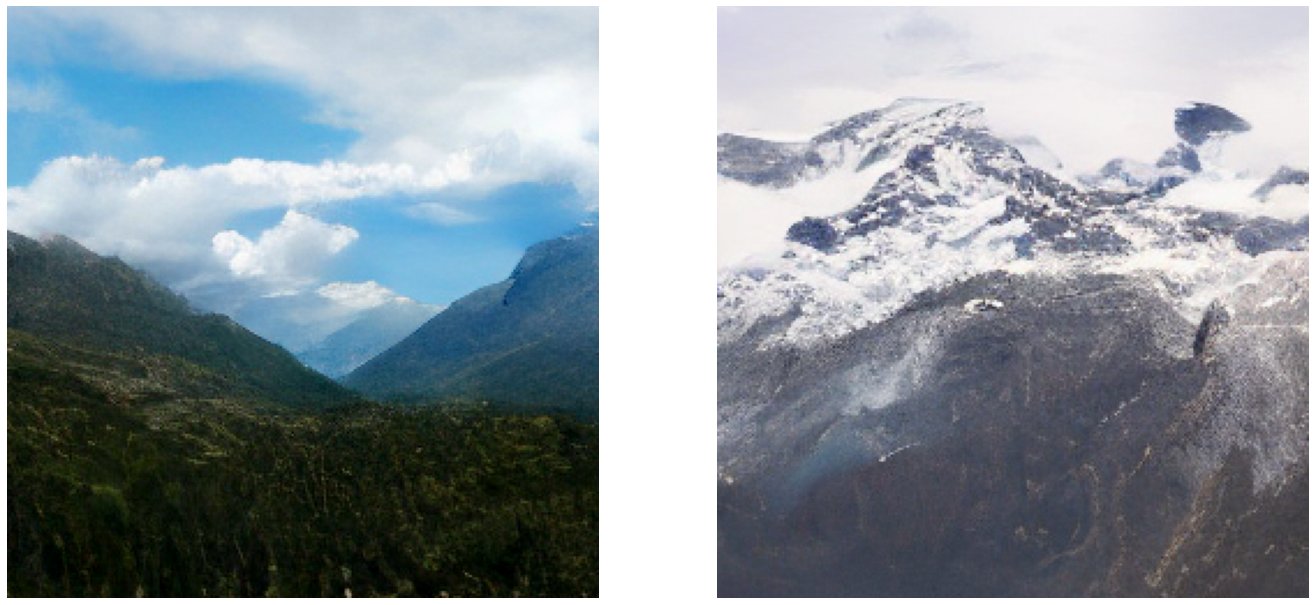

In [ ]:
with torch.no_grad(): pd = to_cpu(vae.decode(s.to(def_device)))

preds = sample(ddim_step, model, (2,4,32,32), steps=100, eta=1., clamp=False)
s = preds[-1]*5

with torch.no_grad(): pd = to_cpu(vae.decode(s.to(def_device)))

show_images(pd['sample'].clamp(0,1), imsize=12)

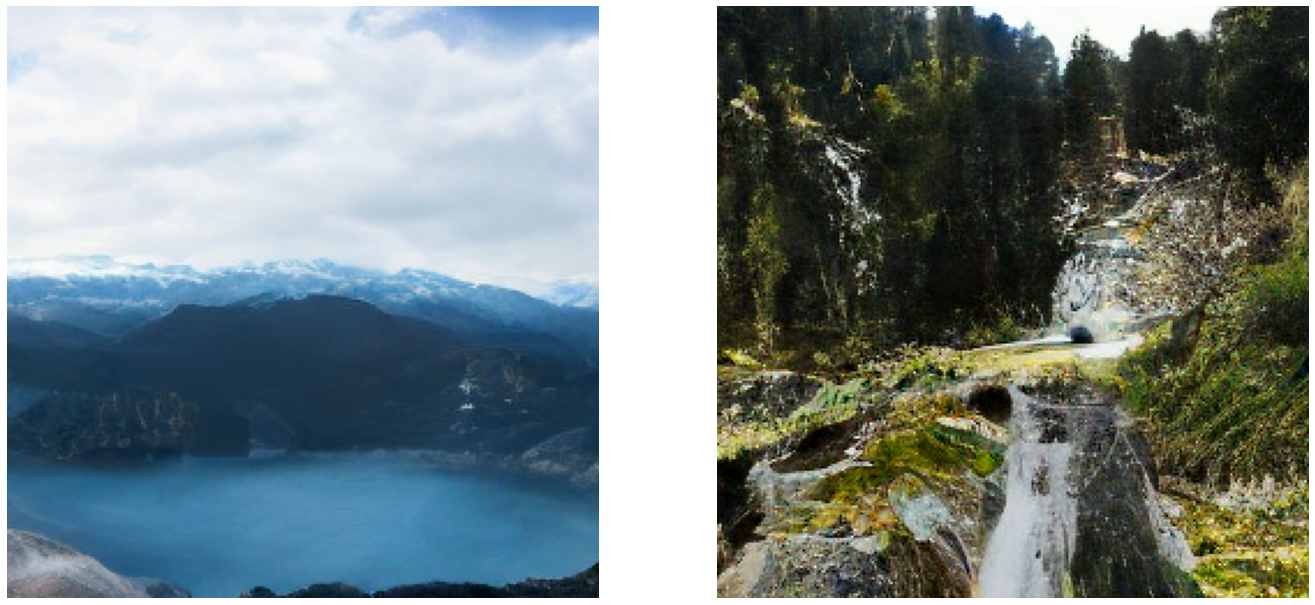

In [ ]:
with torch.no_grad(): pd = to_cpu(vae.decode(s.to(def_device)))

preds = sample(ddim_step, model, (2,4,32,32), steps=100, eta=1., clamp=False)
s = preds[-1]*5

with torch.no_grad(): pd = to_cpu(vae.decode(s.to(def_device)))

show_images(pd['sample'].clamp(0,1), imsize=12)

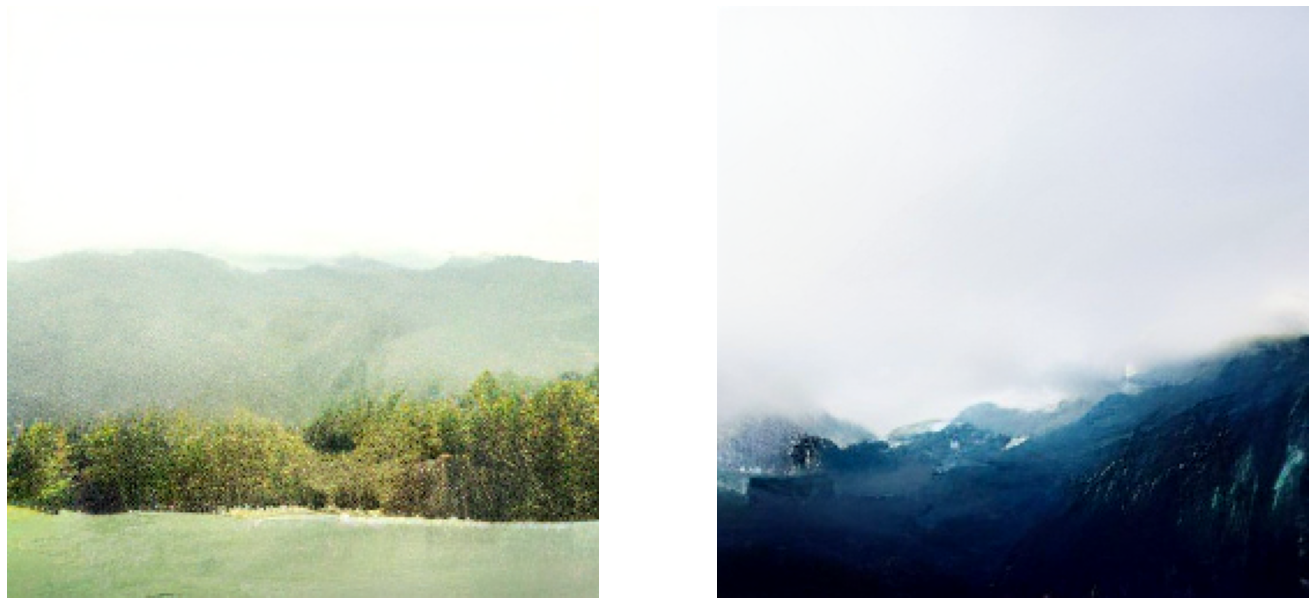

In [ ]:
with torch.no_grad(): pd = to_cpu(vae.decode(s.to(def_device)))

preds = sample(ddim_step, model, (2,4,32,32), steps=100, eta=1., clamp=False)
s = preds[-1]*5

with torch.no_grad(): pd = to_cpu(vae.decode(s.to(def_device)))

show_images(pd['sample'].clamp(0,1), imsize=12)

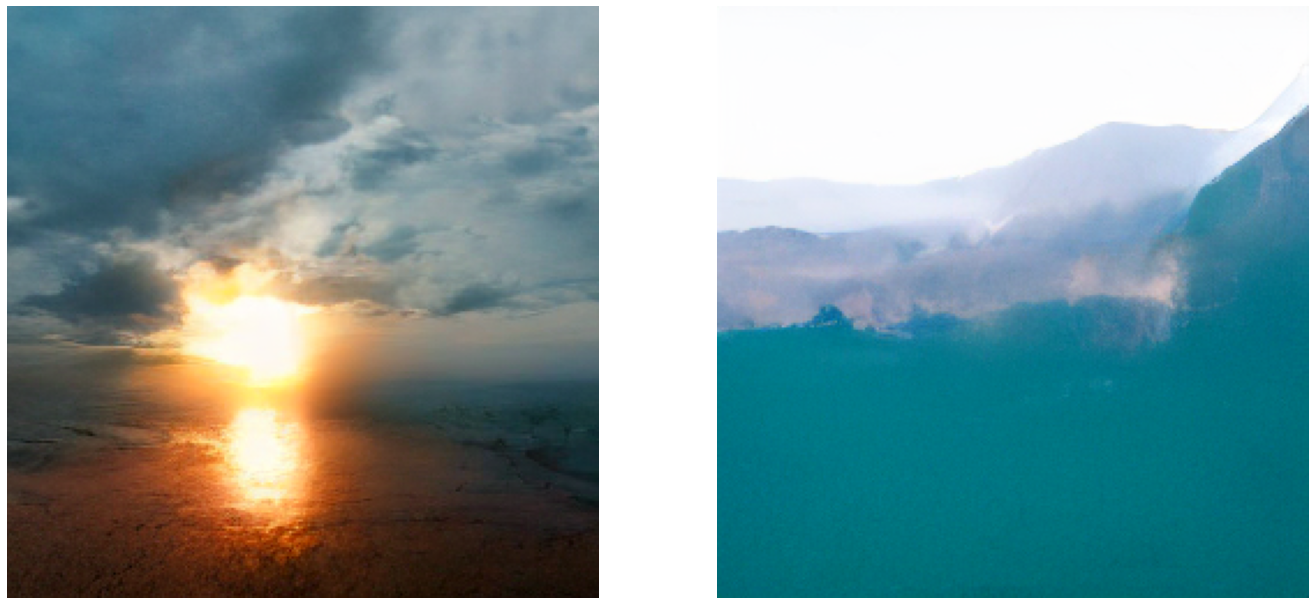

In [ ]:
with torch.no_grad(): pd = to_cpu(vae.decode(s.to(def_device)))

preds = sample(ddim_step, model, (2,4,32,32), steps=100, eta=1., clamp=False)
s = preds[-1]*5

with torch.no_grad(): pd = to_cpu(vae.decode(s.to(def_device)))

show_images(pd['sample'].clamp(0,1), imsize=12)